# Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import WDM
import TimeFrequencyWaveforms as TFW
from TimeFrequencyWaveforms.code import utils

import time

In [2]:
dt = 1.0

Nt, Nf = 512, 128
N = Nt * Nf

wdm = WDM.WDM.WDM_transform(dt=dt, Nf=Nf, N=N, q=8, calc_m0=True)

print(f"Sampling rate fs = {1/dt} Hz")
print(f"Duration T = {N} s = {N/(60*60*24):.1f} days")
print(f"Wavelet time resolution dT = {wdm.dT:.1f} s = {wdm.dT/(60*60):.1f} hours")
print(f"Wavelet frequency resolution dF = {1.0e3*wdm.dF:.1f} mHz")

Sampling rate fs = 1.0 Hz
Duration T = 65536 s = 0.8 days
Wavelet time resolution dT = 128.0 s = 0.0 hours
Wavelet frequency resolution dF = 3.9 mHz


In [3]:
r"""
m = wdm.Nf//2

fig, ax = plt.subplots(figsize=(5,4))
for i, eps in enumerate([0.1, 0.5, 0.9]):
    ax.plot(np.arange(0, wdm.Nt, 2),
            [TFW.new_waveforms.cnm(wdm, n, m, (m+eps)*wdm.dF) for n in range(0, wdm.Nt, 2)],
            color='C{}'.format(i), ls='-', label=r'$f=f_{\rm ref}+'+f'{eps}'+'\\Delta f$')

ax.set_xlim(0, wdm.Nt-1)

ax.set_xlabel('Wavelet index n')
ax.set_ylabel(r'$c_{n,m}(f)$')

ax.legend(loc='center right', frameon=False)

plt.show()
"""

"\nm = wdm.Nf//2\n\nfig, ax = plt.subplots(figsize=(5,4))\nfor i, eps in enumerate([0.1, 0.5, 0.9]):\n    ax.plot(np.arange(0, wdm.Nt, 2),\n            [TFW.new_waveforms.cnm(wdm, n, m, (m+eps)*wdm.dF) for n in range(0, wdm.Nt, 2)],\n            color='C{}'.format(i), ls='-', label=r'$f=f_{\\rm ref}+'+f'{eps}'+'\\\\Delta f$')\n\nax.set_xlim(0, wdm.Nt-1)\n\nax.set_xlabel('Wavelet index n')\nax.set_ylabel(r'$c_{n,m}(f)$')\n\nax.legend(loc='center right', frameon=False)\n\nplt.show()\n"

In [4]:
r"""
fig, ax = plt.subplots(figsize=(5,4))

f_vals = np.linspace(0, 2*wdm.dF, 50)

f_ref = (wdm.Nf//2)*wdm.dF

for i, m in enumerate(np.arange(wdm.Nf//2-2, wdm.Nf//2+3)):
    ax.plot(f_vals,
            [TFW.new_waveforms.cnm(wdm, wdm.Nt//2, m, f+f_ref, fdot=1.0e-5) for f in f_vals],
                color='C{}'.format(i), ls='-', label=r'$m={}$'.format(m))

ax.set_xlim(0, 2*wdm.dF)
ax.set_xticks([0, 0.5*wdm.dF, wdm.dF, 1.5*wdm.dF,2*wdm.dF], 
        labels=[r'$0$', r'$\Delta f/2$', r'$\Delta f$', r'$3\Delta f/2$', r'$2\Delta f$'])

ax.set_xlabel(r'Frequency $f-f_{\rm ref}$ [Hz]')
ax.set_ylabel(r'$c_{nm}(f, \dot{f})$')

ax.legend(loc='upper center', frameon=False)

plt.show()
"""

"\nfig, ax = plt.subplots(figsize=(5,4))\n\nf_vals = np.linspace(0, 2*wdm.dF, 50)\n\nf_ref = (wdm.Nf//2)*wdm.dF\n\nfor i, m in enumerate(np.arange(wdm.Nf//2-2, wdm.Nf//2+3)):\n    ax.plot(f_vals,\n            [TFW.new_waveforms.cnm(wdm, wdm.Nt//2, m, f+f_ref, fdot=1.0e-5) for f in f_vals],\n                color='C{}'.format(i), ls='-', label=r'$m={}$'.format(m))\n\nax.set_xlim(0, 2*wdm.dF)\nax.set_xticks([0, 0.5*wdm.dF, wdm.dF, 1.5*wdm.dF,2*wdm.dF], \n        labels=[r'$0$', r'$\\Delta f/2$', r'$\\Delta f$', r'$3\\Delta f/2$', r'$2\\Delta f$'])\n\nax.set_xlabel(r'Frequency $f-f_{\\rm ref}$ [Hz]')\nax.set_ylabel(r'$c_{nm}(f, \\dot{f})$')\n\nax.legend(loc='upper center', frameon=False)\n\nplt.show()\n"

In [5]:
fdot_grid_spec = (-1.5e-6, 1.5e-6, 5)
transformer = TFW.code.TD_to_TFD_transform.Transformer(wdm, num_freq_points=50, num_pixels=10, fdot_grid_spec=fdot_grid_spec)

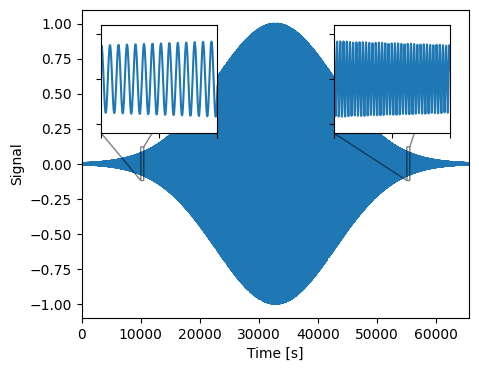

In [6]:
par = {'phic': 1.0, 'tc':32768.0, 'w':10000.0, 'f':0.05, 'fdot':1.0e-6}

def amplitude(t, par):
    tc = par['tc']
    w = par['w']
    return jnp.exp(-0.5*((t-tc)/w)**2)

def phase(t, par):
    tc = par['tc']
    f = par['f']
    fdot = par['fdot']
    phic = par['phic']
    return phic + 2.*jnp.pi*f*(t-tc) + jnp.pi*fdot*(t-tc)**2

def frequency(t, par):
    f = par['f']
    tc = par['tc']
    fdot = par['fdot']
    return f + fdot * (t-tc)

def frequency_deriv(t, par):
    fdot = par['fdot']
    return fdot * jnp.ones_like(t) 


fig, ax = plt.subplots(figsize=(5,4))
ax.plot(wdm.times, amplitude(wdm.times, par)*jnp.cos(phase(wdm.times, par)))

# inset Axes....
x1, x2, y1, y2 = 10000, 10500, -0.12, 0.12  # subregion of the original image
axins = ax.inset_axes(
    [0.05, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(wdm.times, amplitude(wdm.times, par)*jnp.cos(phase(wdm.times, par)))
ax.indicate_inset_zoom(axins, edgecolor="black")

# inset Axes....
x1, x2, y1, y2 = 55000, 55500, -0.12, 0.12  # subregion of the original image
axins_ = ax.inset_axes(
    [0.65, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins_.plot(wdm.times, amplitude(wdm.times, par)*jnp.cos(phase(wdm.times, par)))
ax.indicate_inset_zoom(axins_, edgecolor="black")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal")

ax.set_xlim(wdm.times[0], wdm.times[-1])

plt.show()

In [7]:
t0 = time.time()
t_n = jnp.arange(wdm.Nt)*wdm.dT

A_n = amplitude(t_n, par)
Phi_n = phase(t_n, par)
f_n = frequency(t_n, par)
fdot_n = frequency_deriv(t_n, par)

wnm = transformer.transform(A_n, Phi_n, f_n, fdot_n)
wp, wc = jnp.real(wnm), jnp.imag(wnm)
tc = time.time()
print(f"Elapsed time: {tc - t0} seconds")

Elapsed time: 0.31917500495910645 seconds


In [8]:
t0 = time.time()
Wp = wdm(amplitude(wdm.times, par)*jnp.cos(phase(wdm.times, par)))
Wc = wdm(amplitude(wdm.times, par)*jnp.sin(phase(wdm.times, par)))
tc = time.time()
print(f"Elapsed time: {tc - t0} seconds")

Elapsed time: 0.12111616134643555 seconds


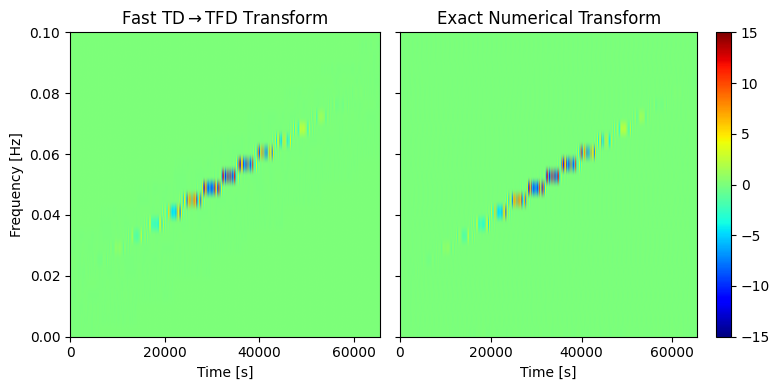

In [9]:
fig, axes = plt.subplots(figsize=(8,4), ncols=2, sharey=True, width_ratios=[1, 1.2])

im = axes[0].imshow(wp.T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')

im_ = axes[1].imshow(Wp.T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')

fig.colorbar(im_, ax=axes[1])

axes[0].set_ylim(0, 0.1)
axes[0].set_ylabel("Frequency [Hz]")
axes[0].set_xlabel("Time [s]")
axes[1].set_xlabel("Time [s]")

axes[0].set_xticks(np.arange(0, 70000, 20000))
axes[1].set_xticks(np.arange(0, 70000, 20000))

axes[0].set_title(r"Fast TD$\rightarrow$TFD Transform")
axes[1].set_title("Exact Numerical Transform")

plt.tight_layout()
plt.show()

In [10]:
def wavelet_inner_product(wdm : WDM.WDM.WDM_transform,
                          Anm : jnp.ndarray, Bnm : jnp.ndarray, 
                          f_low : float=None, f_high : float=None, 
                          t_low : float=None, t_high : float=None) -> float:
    """ 
    Compute white TF noise inner product between two signals with wavelet
    coefficients Anm and Bnm. This is a sum over the time-frequency grid.
    The optional arguments allow this sum to be restricted to a sub-region
    of the time-frequency grid.

    Parameters
    ---------- 
    wdm : WDM.WDM.WDM_transform
        An instance of the WDM wavelet transform class.
    Anm : jnp.ndarray
        Wavelet coefficients of first signal, shape=(Nt, Nf).
    Bnm : jnp.ndarray
        Wavelet coefficients of second signal, shape=(Nt, Nf).
    f_low : float
        Lower frequency bound of inner product. Optional.
    f_high : float
        Upper frequency bound of inner product. Optional.
    t_low : float
        Lower time bound of inner product. Optional.
    t_high : float
        Upper time bound of inner product. Optional.

    Returns
    -------
    AB : float
        The inner product.
    """
    tn = wdm.dT * jnp.arange(wdm.Nt)
    fm = wdm.dF * jnp.arange(wdm.Nf)

    t_low = t_low if t_low is not None else 0.0
    t_high = t_high if t_high is not None else wdm.T
    f_low = f_low if f_low is not None else 0.0
    f_high = f_high if f_high is not None else wdm.f_Ny

    mask = jnp.outer( jnp.logical_and(tn > t_low, tn < t_high),
                      jnp.logical_and(fm > f_low, fm < f_high) )

    AB = jnp.sum(Anm[mask]*Bnm[mask])

    return AB

edge = 50
f_low, f_high = 0.05, 0.1

wW = wavelet_inner_product(wdm, wp, Wp, f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)
ww = wavelet_inner_product(wdm, wp, wp, f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)
WW = wavelet_inner_product(wdm, Wp, Wp, f_low=f_low, f_high=f_high, t_low=edge*wdm.dT, t_high=wdm.T-edge*wdm.dT)

MM = 1.0 - wW/jnp.sqrt(ww*WW)

print(f"Mismatch = {MM:.2e}")

Mismatch = 1.49e-04


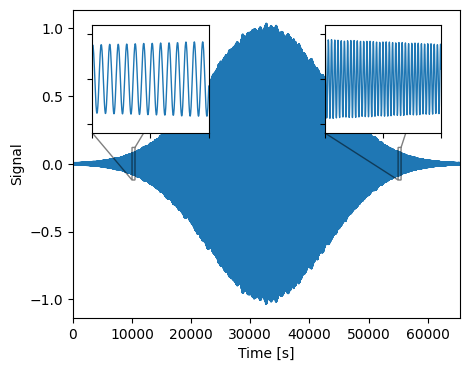

In [11]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(wdm.times, wdm.idwt(wp), color='C0', ls='-')

# inset Axes....
x1, x2, y1, y2 = 10000, 10500, -0.12, 0.12  # subregion of the original image
axins = ax.inset_axes(
    [0.05, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(wdm.times, wdm.idwt(wp), color='C0', ls='-', lw=1)
ax.indicate_inset_zoom(axins, edgecolor="black")

# inset Axes....
x1, x2, y1, y2 = 55000, 55500, -0.12, 0.12  # subregion of the original image
axins_ = ax.inset_axes(
    [0.65, 0.6, 0.3, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins_.plot(wdm.times, wdm.idwt(wp), color='C0', ls='-', lw=1)
ax.indicate_inset_zoom(axins_, edgecolor="black")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal")

ax.set_xlim(wdm.times[0], wdm.times[-1])

plt.show()

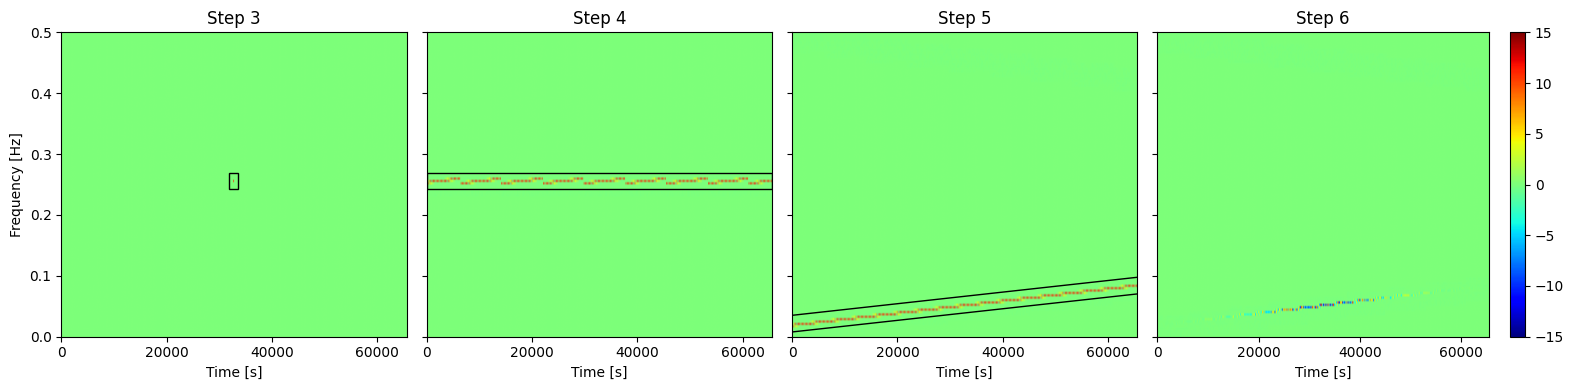

In [12]:
import matplotlib.patches as patches

CNM, _, _, SHATNM = transformer.cnm_snm(A_n, Phi_n, f_n, fdot_n)
WNM = transformer.transform(A_n, Phi_n, f_n, fdot_n)

fig, axes = plt.subplots(figsize=(16,4), ncols=4, sharey=True, width_ratios=[1, 1, 1, 1.2])

M = jnp.zeros_like(CNM)
M = M.at[wdm.Nt//2-1,:].set(CNM[wdm.Nt//2-1,:])
M = M.at[wdm.Nt//2,:].set(CNM[wdm.Nt//2,:])
im = axes[0].imshow(M.T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
rect = patches.Rectangle(((wdm.Nt//2-8)*wdm.dT, (wdm.Nf//2-2)*wdm.dF), 14*wdm.dT, 7*wdm.dF, linewidth=1, edgecolor='k', facecolor='none')
axes[0].add_patch(rect)

im_ = axes[1].imshow(CNM.T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
rect = patches.Rectangle((0, (wdm.Nf//2-2)*wdm.dF), wdm.T, 7*wdm.dF, linewidth=1, edgecolor='k', facecolor='none')
axes[1].add_patch(rect)

z_n = jnp.floor((f_n-transformer.f_ref)/(2*wdm.dF)).astype(int)
CNM_shifted = 0.5 * ( utils.row_roll(CNM, +2*z_n) +
                    utils.row_roll(CNM, -2*z_n) +
                    transformer.alt * utils.row_roll(SHATNM, +2*z_n) -
                    transformer.alt * utils.row_roll(SHATNM, -2*z_n) ) 
im__ = axes[2].imshow(CNM_shifted.T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
axes[2].plot([0,wdm.T], 
                [transformer.f_ref + 2*z_n[0]*wdm.dF-2*wdm.dF, transformer.f_ref + 2*z_n[-1]*wdm.dF-2*wdm.dF], 
                    color='k', ls='-', lw=1)
axes[2].plot([0,wdm.T], 
                [transformer.f_ref + 2*z_n[0]*wdm.dF+5*wdm.dF, transformer.f_ref + 2*z_n[-1]*wdm.dF+5*wdm.dF], 
                    color='k', ls='-', lw=1)

im___ = axes[3].imshow(jnp.real(WNM).T, aspect='auto', origin='lower', vmin=-15, vmax=15,
                extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')

fig.colorbar(im___, ax=axes[3])

axes[0].set_ylabel("Frequency [Hz]")
axes[0].set_xlabel("Time [s]")
axes[1].set_xlabel("Time [s]")
axes[2].set_xlabel("Time [s]")
axes[3].set_xlabel("Time [s]")

axes[0].set_xticks(np.arange(0, 70000, 20000))
axes[1].set_xticks(np.arange(0, 70000, 20000))
axes[2].set_xticks(np.arange(0, 70000, 20000))
axes[3].set_xticks(np.arange(0, 70000, 20000))

axes[0].set_title("Step 3")
axes[1].set_title("Step 4")
axes[2].set_title("Step 5")
axes[3].set_title("Step 6")

plt.tight_layout()
plt.show()